In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
!pip install umap-learn
import umap
!pip install optuna
import optuna
import xgboost as xgb
import functools
import lightgbm as lgb
import time
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

In [ ]:
from cycler import cycler
raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]

light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2]
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2]
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

mpl.rcParams['figure.dpi'] = 200

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

sns.palplot(dark_palette)

In [ ]:
api_token = {"username":"watsons","key":"dc7da47ca9aa5e696b65f97c16fd627b"}
import json
import zipfile
import os
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c tabular-playground-series-may-2021
!unzip \*.zip  && rm *.zip

In [4]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2


In [6]:
print(train.shape)
print(test.shape)

(100000, 52)
(50000, 51)


In [7]:
train.isnull().any().sum()

0

In [8]:
test.isnull().any().sum()

0

In [9]:
train['target'].value_counts()

Class_2    57497
Class_3    21420
Class_4    12593
Class_1     8490
Name: target, dtype: int64

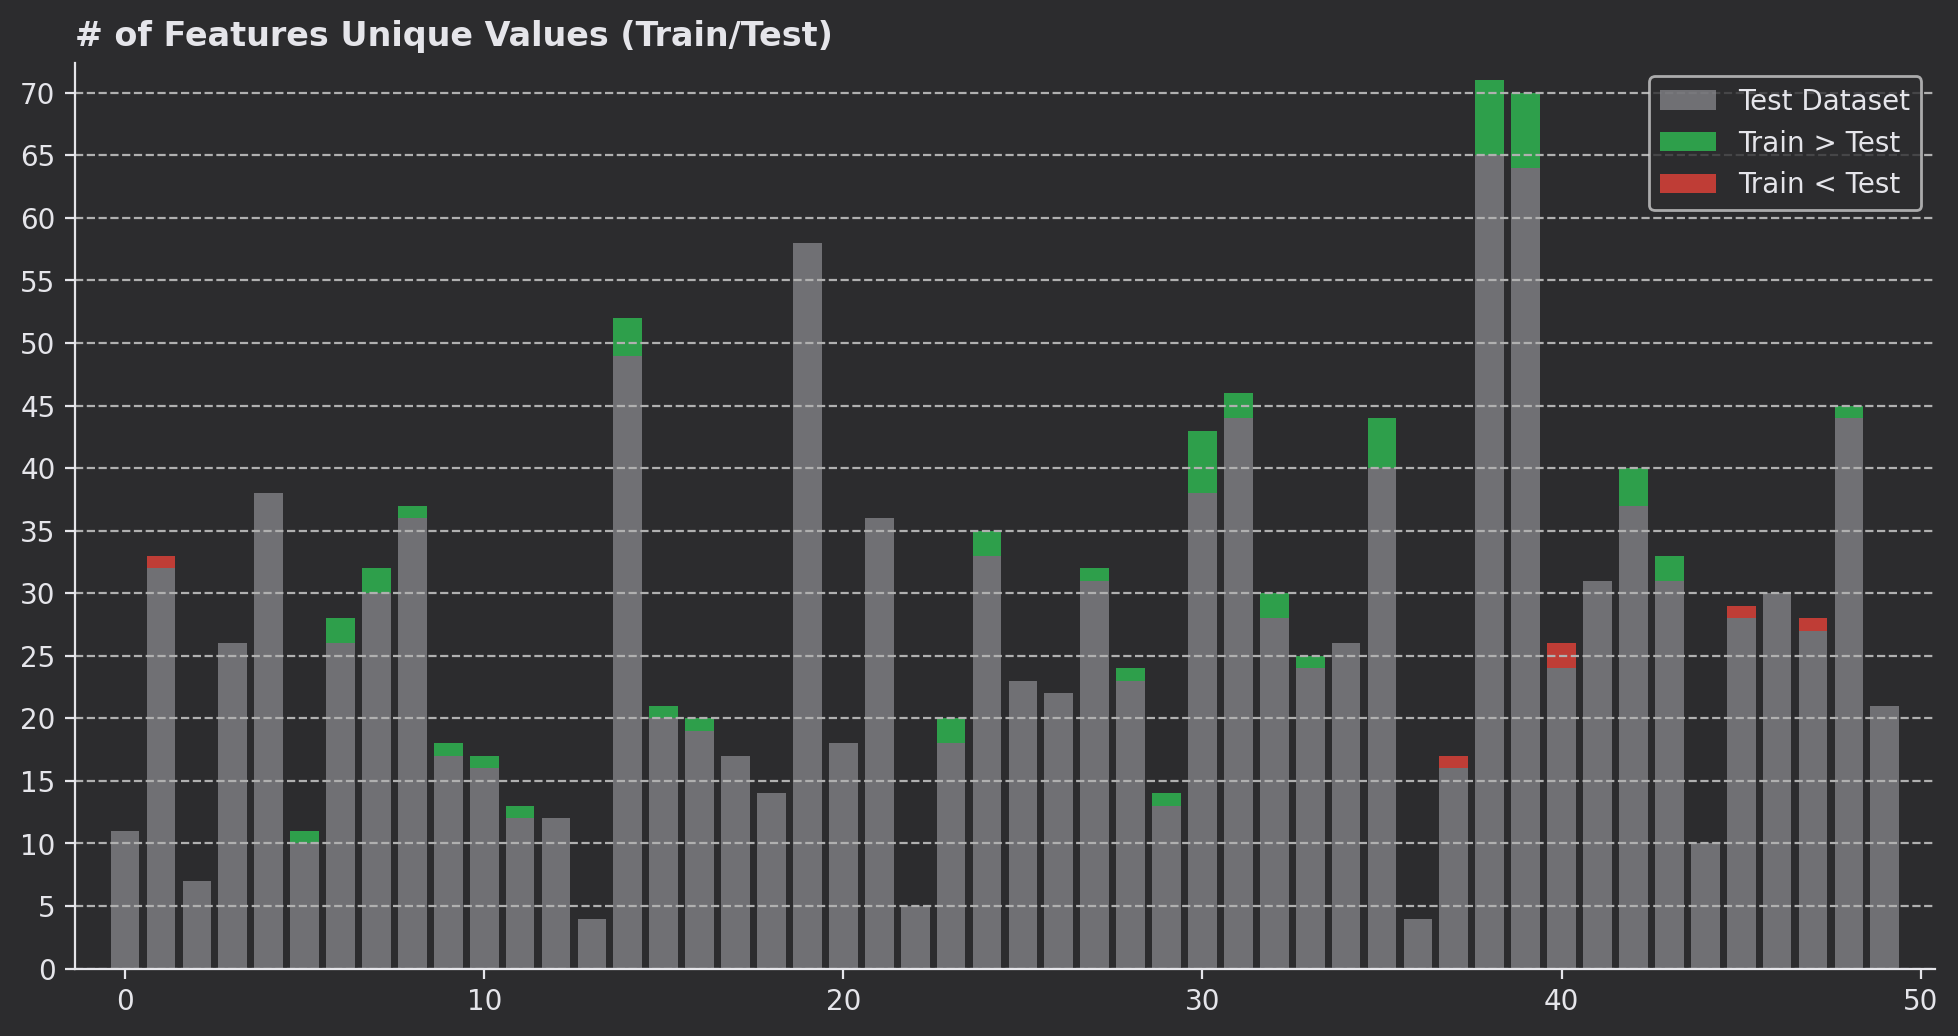

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
y = np.array([train[f'feature_{i}'].nunique() for i in range(50)])
y2 = np.array([test[f'feature_{i}'].nunique() for i in range(50)])
comp = y-y2
ax.bar(range(50), y2, alpha=0.7, color=gray_dark_palette[0], label='Test Dataset')
# Thanks to @rahulchauhan3j to fix typo
ax.bar(range(50),  comp*(comp>0), bottom=y2, color=dark_palette[2], alpha=0.7, label='Train > Test')
ax.bar(range(50), comp*(comp<0), bottom=y2-comp*(comp<0), color=dark_palette[3], alpha=0.7, label='Train < Test')
ax.set_yticks(range(0, 80, 5))
ax.margins(0.02)
ax.grid(axis='y', linestyle='--', zorder=5)
ax.set_title('# of Features Unique Values (Train/Test)', loc='left', fontweight='bold')
ax.legend()
plt.show()


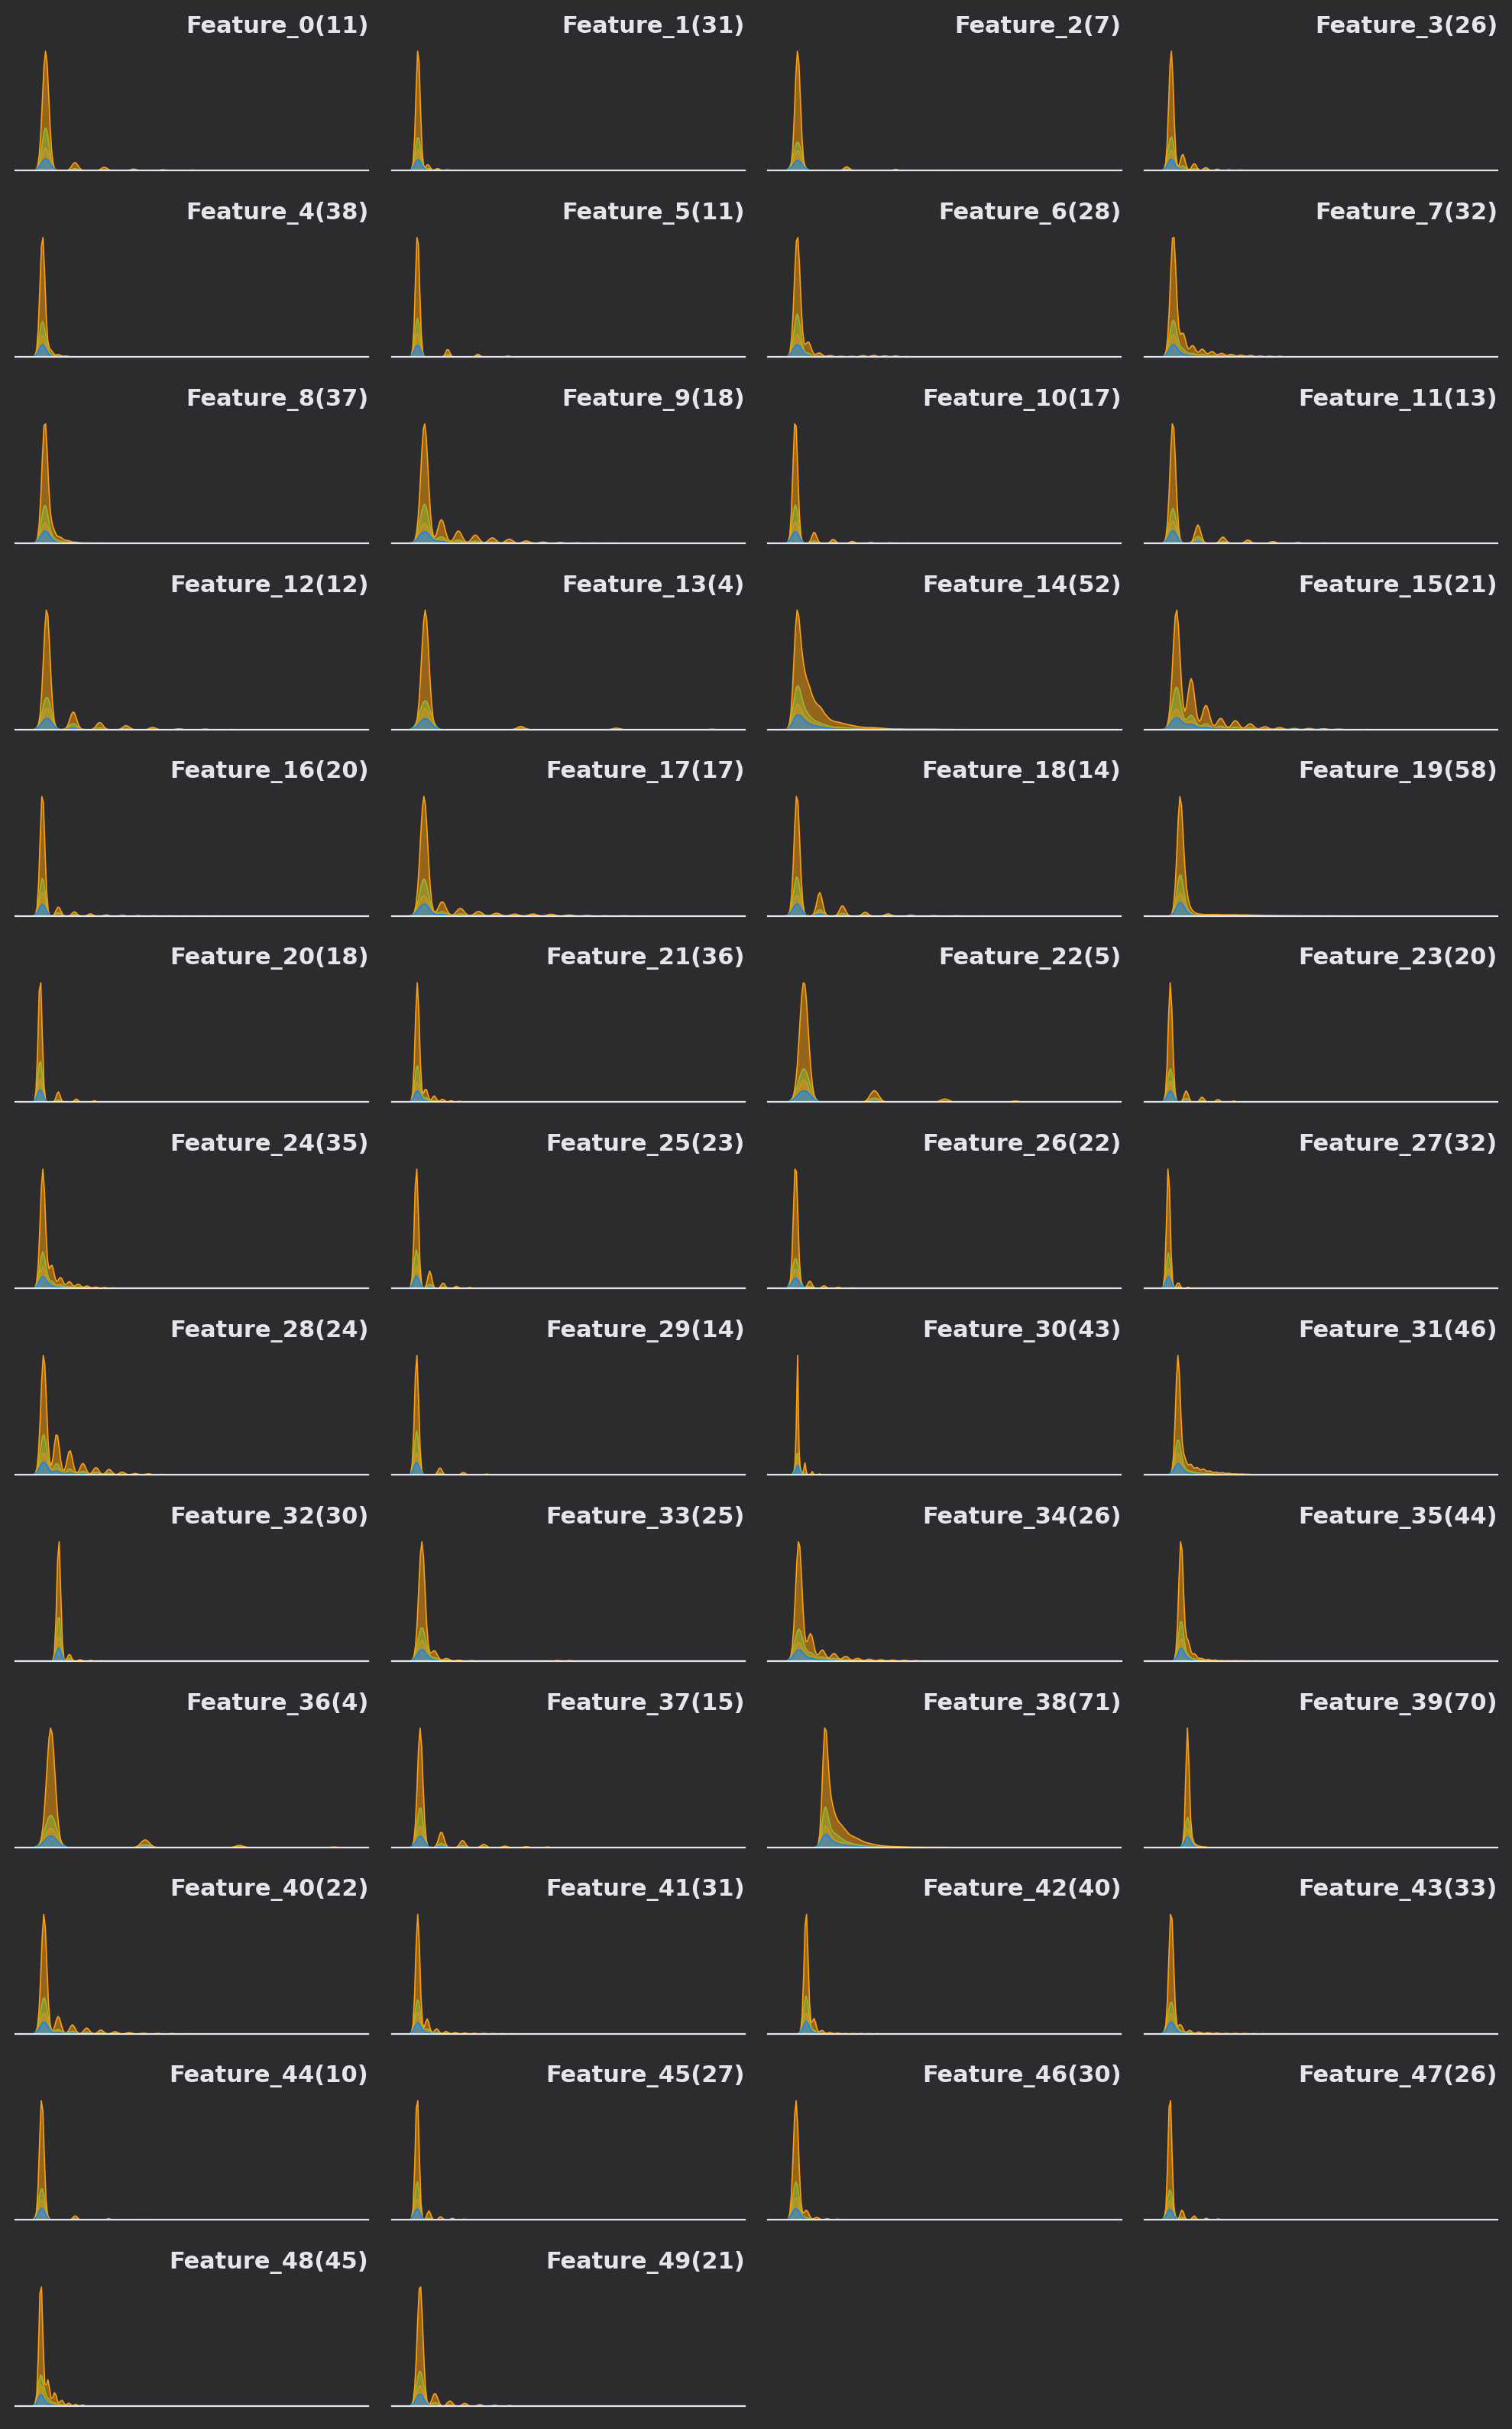

In [11]:

fig, axes = plt.subplots(13, 4, figsize=(10, 16))
target_order = sorted(train['target'].unique())

for idx, ax in zip(range(50), axes.flatten()):
    cnt = train[f'feature_{idx}'].value_counts().sort_index()
    sns.kdeplot(x=f'feature_{idx}', 
    hue='target', hue_order=target_order,
    data=train,
    alpha=0.5, 
    linewidth=0.6, fill=True,
    legend=False,
    ax=ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    cnt = len(train[f'feature_{idx}'].unique())
    ax.set_title(f'Feature_{idx}({cnt})', loc='right', weight='bold', fontsize=11)

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

fig.tight_layout()
plt.show()


因為標籤不平衡，這裡設計downsampling的函數，後來測試分數不佳就沒有使用



In [12]:
def balanced_subsample(train,size=None):
    subsample = []
    if size is None:
        n_smp = train['target'].value_counts().min()
    else:
        n_smp = int(size / len(train['target'].value_counts().index))
    for label in train['target'].value_counts().index:
        samples = train[train['target'] == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()
    return subsample

In [13]:
train.set_index('id',drop=True,inplace=True)
y=train.target
one_hot_y=pd.get_dummies(y)
train.drop('target',axis=1,inplace=True)
test.set_index('id',drop=True,inplace=True)
train_test=pd.concat([train,test])

防止label encoding的時候測試集沒有訓練集的資料，把測試集獨有的資料壓成0

In [ ]:
'''
for i,col in enumerate(train.columns):
    replace=list(set(test.iloc[:,i]).difference(set(train.iloc[:,i])))
    for num in replace:
        test.iloc[:,i].replace(num,0,inplace=True)
'''

生成列的統計數據當作是特徵

In [15]:
class variables:
    def _init_(self,data):
        self.data=data
    def statistics(self,data,combined):
        combined['sum']=data.sum(1)
        combined['avg']=data.mean(1)
        combined['max']=data.max(1)
        combined['min']=data.min(1)
        combined['median']=data.median(1)
        combined['std']=data.std(1)
        combined['count0']=data.isin([0]).sum(1)
        return combined

設計了target encoding搭配kfold的class，設計了變數轉換方式搭配是否使用umap降維，最後選擇了label encoding搭配不降維的特徵(因降維後新增的特徵沒有甚麼作用)

In [ ]:
class encoding:
    def _init_(self,train_dup):
        self.train=train_dup
    def target_encoding(self,train_dup,y,kf):
        columns=train_dup.columns
        for c in columns:
            data_tmp=pd.DataFrame({c:train_dup[c],'target':y})
            tmp=np.repeat(np.nan,train_dup.shape[0])
            for i,(tr_idx,va_idx) in enumerate(kf.split(train_dup)):
                target_mean=data_tmp.iloc[tr_idx].groupby(c)['target'].mean()
                tmp[va_idx]=train_dup[c].iloc[va_idx].map(target_mean)
            train_dup[c]=tmp
        train_dup.fillna(0,inplace=True)
        return train_dup
'''
kf=KFold(n_splits=5, random_state=23, shuffle=True)
train_for=train
train_dup=train
logsave=pd.DataFrame(np.zeros((60,4)))
logsave.columns=['col','cat','down','score']
count=0
t1 = time.time()

collist=['Class_1','Class_2','Class_3','Class_4']
catlist=['ordinal','standard','one_hot','target_enc','nothing']
downlist=['lda','umap','nothing']
for col in range(4):
    ytrain=one_hot_y.iloc[:,col]
    for cat in range(5):
        if(cat==0):
            ordinal=preprocessing.OrdinalEncoder().fit(train_for)
            xtrain=pd.DataFrame(ordinal.transform(train_for),columns=train_for.columns)
        elif(cat==1):
            xtrain=preprocessing.StandardScaler().fit_transform(train_for)
        elif(cat==2):
            one_hot=preprocessing.OneHotEncoder().fit(train_for)
            xtrain=pd.DataFrame(one_hot.transform(train_for).toarray())
            xtrain.columns=one_hot.get_feature_names(train_for.columns)
        elif(cat==3):
            xtrain=encoding().target_encoding(train_dup,one_hot_y.iloc[:,col],kf)
        else:
            xtrain=train
        for down in range(2):
            xtrain=pd.DataFrame(xtrain)
            if(down==0):
                um=umap.UMAP()
                xtrain_down =um.fit_transform(xtrain)
                xtrain_down=pd.DataFrame(xtrain_down)
                xtrain_down=pd.concat([xtrain_down,xtrain],axis=1)
            else:
                xtrain_down=xtrain

            xtrain_down=variables().statistics(train_for,xtrain_down)

            lgbc=lgb.LGBMClassifier()
            scores = cross_val_score(lgbc,xtrain_down,one_hot_y.iloc[:,col],scoring='neg_log_loss',cv=kf)
            score=-round(scores.mean(),3)

            logsave.iloc[count,:]=[collist[col],catlist[cat],downlist[down],score]
            count+=1
            print(count)
            t2 = time.time()   
            print('time elapsed: ' + str(round(t2-t1, 2)) + ' seconds')
            print(list(logsave.iloc[count,:]))
'''        

lgbm使用optuna尋找最佳超參數

In [17]:
def lb_opt(xtrain,ytrain,trial):

    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    n_estimators = trial.suggest_int('n_estimators',10,500),
    min_child_samples = trial.suggest_int('n_estimators',10,30),
    reg_lambda =trial.suggest_float('reg_lambda',0.,1.)
    reg_alpha = trial.suggest_float('reg_alpha',0.,1.)
    subsample = trial.suggest_float('subsample',0.5,1.)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1.)
    lightgbm_tuna = lgb.LGBMClassifier(
        random_state = 0,
        verbosity = 1,
        bagging_seed = 0,
        metric = 'binary_logloss',
        min_child_samples = min_child_samples,
        reg_alpha = reg_alpha,
        reg_lambda =reg_lambda,
        bagging_freq = bagging_freq ,
        min_data_in_leaf = min_data_in_leaf,
        max_depth = max_depth,
        learning_rate = learning_rate,
        num_leaves = num_leaves,
        num_threads = num_threads,
        min_sum_hessian_in_leaf = min_sum_hessian_in_leaf,
        colsample_bytree=colsample_bytree,
        subsample = subsample
    )
    kf=KFold(n_splits=5, random_state=23, shuffle=True)
    scores = cross_val_score(lightgbm_tuna,xtrain,ytrain,scoring='neg_log_loss',cv=kf)
    score = -round(scores.mean(),3)
    return score

In [19]:
ordinal=preprocessing.OrdinalEncoder().fit(train_test)
x=pd.DataFrame(ordinal.transform(train_test),columns=train.columns)
x=variables().statistics(train_test,x)
ytrain=preprocessing.LabelEncoder().fit_transform(y)
x_std=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(train_test),columns=train_test.columns)
x_con=pd.concat([x,x_std],axis=1)

將特徵當作數值變數生成兩兩變數處理作為一種特徵生成

In [25]:
def lgb_select(save,inputcol):
  lgbm = lgb.LGBMClassifier() 
  lgbm.fit(save.iloc[:100000,:],one_hot_y.iloc[:,inputcol])
  booster = lgbm.booster_
  importance = booster.feature_importance(importance_type='split')
  feature_name = booster.feature_name()
  feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
  feature_importance.sort_values(by='importance',ascending=False,inplace=True)
  save_select=save[feature_importance.iloc[:100,0]]
  return save_select

def feature_select(inputcol):
  save=pd.DataFrame()
  for col in range(49):
    for col2 in range(col+1,50):
      plus=str(col)+'+'+str(col2)
      save[plus]=train_test.iloc[:,col]+train_test.iloc[:,col2]

  save_select=lgb_select(save,inputcol)
  save=pd.DataFrame()
  for col in range(49):
    for col2 in range(col+1,50):
      plus=str(col)+'-'+str(col2)
      save[plus]=train_test.iloc[:,col]-train_test.iloc[:,col2]
  save_select=pd.concat([save_select,lgb_select(save,inputcol)],axis=1)

  save=pd.DataFrame()
  for col in range(49):
    for col2 in range(col+1,50):
      plus=str(col)+'*'+str(col2)
      save[plus]=train_test.iloc[:,col]*train_test.iloc[:,col2]
  save_select=pd.concat([save_select,lgb_select(save,inputcol)],axis=1)

  save=pd.DataFrame()
  for col in range(49):
    for col2 in range(col+1,50):
      plus=str(col)+'/'+str(col2)
      save[plus]=train_test.iloc[:,col]/train_test.iloc[:,col2]
  save_select=pd.concat([save_select,lgb_select(save,inputcol)],axis=1)
  return save_select

針對四種標籤分開預測，使用lgbm建模後只使用變數重要性前兩百的特徵，再使用optuna做超參數調整

In [27]:

out=pd.DataFrame()
for i in range(4):
  xselect = feature_select(i)
  x_final=pd.concat([x_con,xselect],axis=1)
  lgbm = lgb.LGBMClassifier() 
  lgbm.fit(x_final.iloc[:100000,:],one_hot_y.iloc[:,i])
  booster = lgbm.booster_
  importance = booster.feature_importance(importance_type='split')
  feature_name = booster.feature_name()
  feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
  feature_importance.sort_values(by='importance',ascending=False,inplace=True)
  x_final_select=x_final[feature_importance.iloc[:200,0]]
  optuna.logging.disable_default_handler()
  lb_study = optuna.create_study()
  lb_study.optimize(functools.partial(lb_opt,x_final_select.iloc[:100000,:],one_hot_y.iloc[:,i]),n_trials = 50)
  lgbm = lgb.LGBMClassifier(**lb_study.best_params) 
  lgbm.fit(x_final_select.iloc[:100000,:],one_hot_y.iloc[:,i])
  tmp=pd.DataFrame(lgbm.predict_proba(x_final_select.iloc[100000:,:]))
  out=pd.concat([out,tmp.iloc[:,1]],axis=1)

In [34]:
warnings.simplefilter(action='ignore', category=FutureWarning)
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_final_select.columns)), columns=['Value','Feature'])

plt.figure(figsize=(40, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

嘗試在預測後使用預測值再當作特徵做staking，但是public的分數並不佳

In [ ]:
'''
out.columns=one_hot_y.columns
out2.columns=one_hot_y.columns
xtrain_plusout=pd.concat([xtrain_std,out2],axis=1)
xtest_plusout=pd.concat([xtest_std,out],axis=1)
lgbm = lgb.LGBMClassifier()
lgbm.fit(xtrain_plusout,ytrain)
out3=pd.DataFrame(lgbm.predict_proba(xtest_plusout))
out3.head()
'''

In [30]:
for i in range(4):
  sample_submission.iloc[:,i+1]=out.iloc[:,i]
sample_submission

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.090869,0.568852,0.169592,0.124775
1,100001,0.089984,0.690668,0.154593,0.083054
2,100002,0.087498,0.628920,0.209895,0.098604
3,100003,0.082066,0.564257,0.201009,0.097070
4,100004,0.079739,0.618979,0.173976,0.111358
...,...,...,...,...,...
49995,149995,0.086542,0.688997,0.169032,0.060817
49996,149996,0.083898,0.680449,0.150975,0.131205
49997,149997,0.081471,0.513241,0.247893,0.181471
49998,149998,0.083816,0.633038,0.151281,0.155503


In [31]:
sample_submission.to_csv('upload.csv',index=False)

In [ ]:
!kaggle competitions submit -c tabular-playground-series-may-2021 -f upload.csv -m "upload"